## Setup

In [101]:
from scipy.io import loadmat, savemat
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from matplotlib import pyplot as plt
import mne
import numpy as np
import pandas as pd
import os
import re
import random
import math
import copy

In [102]:
%matplotlib inline
# mne.set_log_level('ERROR')

## Global variables and helper functions

In [105]:
'''Some global variables'''

MAT_DIR = '../Results/DesignMatrix/Stimulus_congruency'
SET_DIR = '../Results/Epoch_stimulus_correctTrials'
DECODE_DIR = '../Results/Decode_Stimulus_congruency'
MAT_REGEX = r'(?P<id>[A-Z0-9_]+)_epochsAll_designMat.mat'
SET_REGEX = r'(?P<id>[A-Z0-9_]+)_epochsAll.set'
MAT_FORMAT = '{ID}_epochsAll_designMat.mat'
SET_FORMAT = '{ID}_epochsAll.set'
DECODE_FORMAT = '{ID}_decode_{TARGET}_{MODEL}.csv'

DESIGN_COLUMNS = {
    'epoch_n': int,
    'artifact_flag': 'category',
    'bin_indicator': 'category',
    'avg_reward': float,
    'reward': float,
    'iti': float,
    'trial_num': float,
    'run_num': float,
    'trial_in_run': float,
    'rt': float,
    'congruency_dc': 'category',
    'acc_dc': 'category',
    'previous_congruency_dc': 'category',
    'previous_acc': 'category',
    'trial_type': 'category',
    'trial_type': 'category',
    'key_rep': 'category',
    'cnv_amplitude': float
}

EVENT_IDS = {
    'congruency_dc': {
        'congruent': 0,
        'incongruent': 1
    }
}

'''Some helper functions'''

def get_ids():
    matches = [re.match(MAT_REGEX, f) for f in os.listdir(MAT_DIR)]
    ids = [match.group('id') for match in matches if match]

    return ids


def convert_snake_case(s):
    result = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', s)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', result).lower()


def read_design(path):
    mat = loadmat(path)
    columns = np.hstack(mat['epochs_allVars'].flat)
    df = pd.DataFrame(data=mat['epochs_all'], columns=columns)

    df.columns = map(convert_snake_case, df.columns)

    for c in df.columns:
        df[c] = df[c].astype(DESIGN_COLUMNS[c])

    return df


def read_epochs(id_):
    mat_file_path = os.path.join(MAT_DIR, MAT_FORMAT.format(ID=id_))
    set_file_path = os.path.join(SET_DIR, SET_FORMAT.format(ID=id_))

    epochs = mne.io.read_epochs_eeglab(set_file_path)
    epochs.metadata = read_design(mat_file_path)

    return epochs


def clean_epochs(epochs, tmin=-0.2, tmax=0.8, freq=100, drop_na=True, drop_artifacts=True, drop_err=True):
    epochs = (epochs.copy().filter(l_freq=None, h_freq=30, n_jobs=3).crop(tmin, tmax).resample(freq))
    epochs.drop_channels(['M1', 'M2', 'SO1', 'LO1', 'IO1', 'LO2'])
    if drop_na:
        epochs = epochs.drop([any(nulls) for nulls in epochs.metadata.isnull().values])
    if drop_artifacts:
        epochs = epochs.drop(epochs.metadata['artifact_flag'] == 0)
    if drop_err:
        epochs = epochs.drop(epochs.metadata['acc_dc'] == 1)

    return epochs


def set_target_as_event(epochs, target, event_ids=None):
    epochs = epochs.copy()
    epochs.events[:, 2] = epochs.metadata[target]
    if event_ids:
        epochs.event_id = event_ids

    return epochs


def get_Xy(epochs, target, dont_equalize_events=False):
    epochs = epochs.copy()

    if str(epochs.metadata[target].dtype) == 'category' and not dont_equalize_events:
        epochs = set_target_as_event(epochs, target, EVENT_IDS.get(target, None))
        epochs, _ = epochs.equalize_event_counts(sorted(EVENT_IDS[target]))

    X = epochs.get_data()
    y = epochs.metadata[target]

    return X, y


def decode(X, y, estimator, scoring, cv=10, n_jobs=1, n_permutes=0):
    sliding_estimator = mne.decoding.SlidingEstimator(estimator, scoring=scoring)
    scores = mne.decoding.cross_val_multiscore(sliding_estimator, X, y, cv=cv, n_jobs=n_jobs)
    mean_scores = np.mean(scores, axis=0)

    scores_permuted_z = np.nan

    if n_permutes > 0:
        scores_permuted = np.zeros((n_permutes, scores.shape[-1]))
        y_shuffled = copy.deepcopy(y)

        for p in range(0, n_permutes):  # run decoding with shuffled target (y) n_permutes times
            print("Running permutation {0}...".format(p + 1))
            y_shuffled.reindex(np.random.permutation(y_shuffled.index))
            y_shuffled.sort_index(inplace=True)
            scores_temp = mne.decoding.cross_val_multiscore(sliding_estimator, X, y_shuffled, cv=cv, n_jobs=n_jobs)  # store permuted values
            scores_permuted[p,...] = np.mean(scores_temp, axis=0)

        scores_permuted_mean = np.mean(scores_permuted, axis=0)  #  mean of permutes at each time point
        scores_permuted_sd = np.std(scores_permuted, axis=0)  #  std of permutes at each time point
        scores_permuted_z = (mean_scores - scores_permuted_mean) / scores_permuted_sd

    return mean_scores, scores_permuted_z


def group_decode(target, estimator, scoring, n=10, n_permutes=0, cv=10):
    ids = get_ids()
    random.shuffle(ids)

    all_scores = []
    all_scores_permuted_z = []

    for i in range(min(n, len(ids))):  # for each subject
        print("Processing subject " + ids[i])
        epochs = read_epochs(ids[i])
        epochs = clean_epochs(epochs)
        X, y = get_Xy(epochs, target)
        scores, scores_permuted_z = decode(X, y, estimator, scoring, cv=cv, n_permutes=n_permutes)

        scores_df = pd.DataFrame({'id': ids[i], 'times': epochs.times, 'scores': scores, 'scores_permuted_z': scores_permuted_z})
        scores_df.to_csv(os.path.join(DECODE_DIR, DECODE_FORMAT.format(ID=ids[i], TARGET=target, MODEL=type(estimator).__name__)))

        all_scores.append(scores)
        all_scores_permuted_z.append(scores_permuted_z)

    mean_scores = np.mean(all_scores, axis=0)
    mean_scores_permuted_z = np.mean(all_scores_permuted_z, axis=0)

    return epochs.times, all_scores, mean_scores, all_scores_permuted_z, mean_scores_permuted_z


def plot_scores(times, scores, title, x_label='time (s)', y_label='AUC', chance=None):
    fig, ax = plt.subplots()

    ax.plot(times, scores)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    ax.axvline(.0, color='k', linestyle='-')

    if chance is not None:
        ax.axhline(chance, color='k', linestyle='--')

    plt.show()


def plot_multi_scores(times, scores, title, x_label='time (s)', y_label='AUC', chance=None, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    n_rows = math.ceil(np.sqrt(len(scores)))
    n_columns = math.ceil(len(scores) / n_rows)

    for i in range(len(scores)):
        plt.subplot(n_rows, n_columns, i + 1)
        plt.plot(times, scores[i])

    plt.show()

## 1. Decode congruency

In [104]:
estimator = make_pipeline(StandardScaler(), svm.SVC())
times, scores, mean_scores, scores_permuted_z, mean_scores_permuted_z = group_decode('congruency_dc', estimator, 'roc_auc', n=25, n_permutes=250, cv=10)

Processing subject AB_06
Running permutation 1...
Running permutation 2...
Running permutation 3...
Running permutation 4...
Running permutation 5...
Running permutation 6...
Running permutation 7...
Running permutation 8...
Running permutation 9...
Running permutation 10...
Running permutation 11...
Running permutation 12...
Running permutation 13...
Running permutation 14...
Running permutation 15...
Running permutation 16...
Running permutation 17...
Running permutation 18...
Running permutation 19...
Running permutation 20...
Running permutation 21...
Running permutation 22...
Running permutation 23...
Running permutation 24...
Running permutation 25...
Running permutation 26...
Running permutation 27...
Running permutation 28...
Running permutation 29...
Running permutation 30...
Running permutation 31...
Running permutation 32...
Running permutation 33...
Running permutation 34...
Running permutation 35...
Running permutation 36...
Running permutation 37...
Running permutation 38

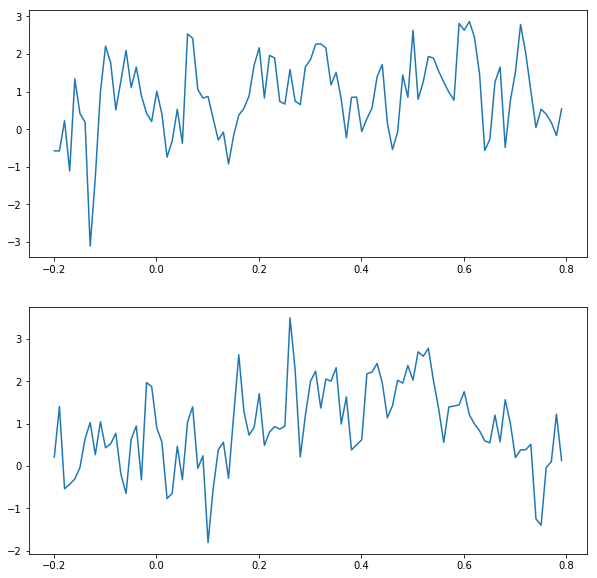

In [107]:
plot_multi_scores(times, scores_permuted_z, 'Decoding Congruency with Time-Domain Data (SVM)')

In [ ]:
plot_scores(times, mean_scores_permuted_z, 'Decoding Congruency with Time-Domain Data (SVM)')

## 2. Decode reaction time

In [52]:
estimator = make_pipeline(StandardScaler(), svm.SVR())
times, scores, mean_scores = group_decode('rt', estimator, 'neg_mean_absolute_error', n=2, n_permutes=250, cv=10)

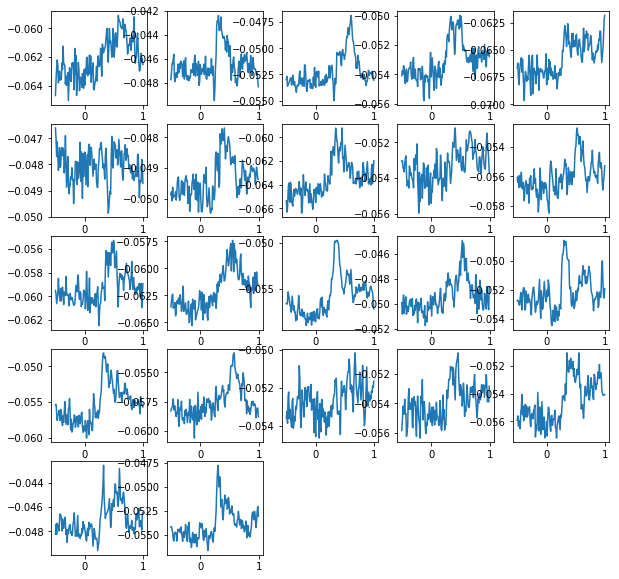

In [53]:
plot_multi_scores(times, scores, 'Decoding Reaction Time with Time-Domain Data (SVM)', y_label='Neg. MAE')

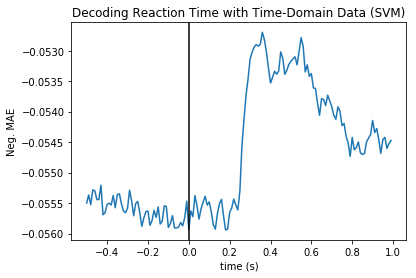

In [54]:
plot_scores(times, mean_scores, 'Decoding Reaction Time with Time-Domain Data (SVM)', y_label='Neg. MAE')

## 3. Decode average reward

In [ ]:
estimator = make_pipeline(StandardScaler(), svm.SVR())
times, scores, mean_scores = group_decode('avg_reward', estimator, 'neg_mean_absolute_error', n=2, n_permutes=250, cv=10)

Processing subject GG_05
Running permutation 1...
Running permutation 2...
Running permutation 3...
Running permutation 4...
Running permutation 5...
Running permutation 6...
Running permutation 7...
Running permutation 8...
Running permutation 9...
Running permutation 10...
Running permutation 11...
Running permutation 12...
Running permutation 13...
Running permutation 14...
Running permutation 15...
Running permutation 16...
Running permutation 17...
Running permutation 18...
Running permutation 19...
Running permutation 20...
Running permutation 21...
Running permutation 22...
Running permutation 23...
Running permutation 24...
Running permutation 25...
Running permutation 26...
Running permutation 27...
Running permutation 28...
Running permutation 29...
Running permutation 30...
Running permutation 31...
Running permutation 32...
Running permutation 33...
Running permutation 34...
Running permutation 35...
Running permutation 36...
Running permutation 37...
Running permutation 38

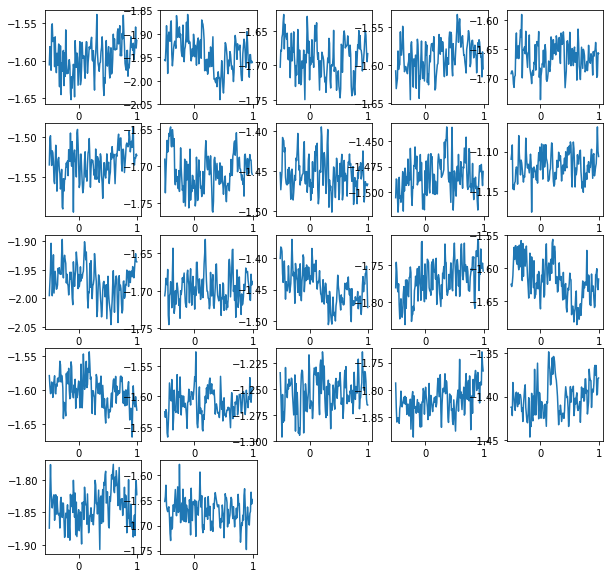

In [56]:
plot_multi_scores(times, scores, 'Decoding Average Reward with Time-Domain Data (SVM)', y_label='Neg. MAE')

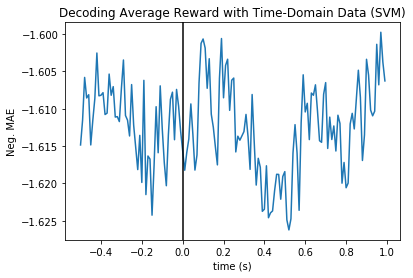

In [57]:
plot_scores(times, mean_scores, 'Decoding Average Reward with Time-Domain Data (SVM)', y_label='Neg. MAE')